In [1]:
import numpy as np

from ADAPTIVE_QAOA.adaptive_qaoa_src.Ansatz import *
import scipy as sc
from qiskit.visualization import plot_histogram

In [5]:
from itertools import product
N_QUBITS = 2
native_gates = ['X','Y','Z']
qubit_list   = [qubit for qubit in range(N_QUBITS)]
single_qubit_gate_combinations = list(product(native_gates,repeat = N_QUBITS))

single_qubit_gate_combinations

[('X', 'X'),
 ('X', 'Y'),
 ('X', 'Z'),
 ('Y', 'X'),
 ('Y', 'Y'),
 ('Y', 'Z'),
 ('Z', 'X'),
 ('Z', 'Y'),
 ('Z', 'Z')]

In [65]:
# Generating random graph 
n = 4
rng_seed = int(np.random.randint(0,2**31-1))
np.random.seed(rng_seed)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = generate_random_graph(nodes=n,weighted=True,w_min=1e-2,seed=rng_seed)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)


Best solution = [1 1 0 1] cost = -2.7826000000000004


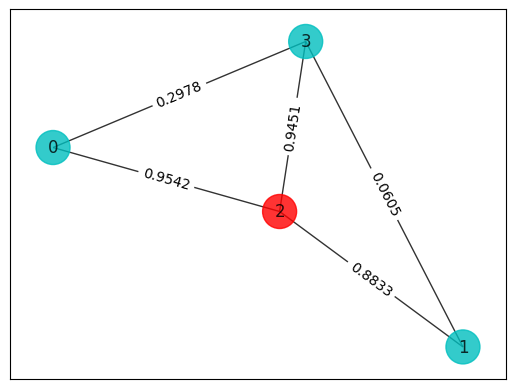

In [66]:
# Calculating optimal partition and plotting
best_cost, best_perm = qubo_min_cost_partition(nr_nodes=n,Q_mat=get_qubo(size=n,edges=edge_list))
colors = ["r" if best_perm[i] == 0 else "c" for i in range(n)]
print("\nBest solution = " + str(best_perm) + " cost = " + str(best_cost))
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [67]:
# Defining instance of QAOA ansatz
QAOA_objective = ADAPTIVEQAOAansatz(n_qubits=n,w_edges=edge_list, backend="SYMQ", precision=64)

In [68]:
# Number of repetitions of (cost, mixer) in circuit
layers=2

# Initial guess for parameters (beta, gamma) of circuit
np.random.seed(0)
theta_min, theta_max = -np.pi, np.pi
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=2*layers)

# ------ Optimizer run ------ #

# Optimizer technique 1)
#_available_methods_ = ['Nelder-Mead', 'Powell', 'COBYLA', 'trust-constr']
#res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[2])

# Optimizer technique 2)
#res = sc.optimize.basinhopping(func=QAOA_objective.evaluate_circuit, x0=theta_i, niter=10, stepsize=0.75)

# Optimizer technique 3)
#_available_strategies_ = ['best1bin', 'best1exp', 'rand1exp', 'randtobest1exp', 'currenttobest1exp', 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']
#res = sc.optimize.differential_evolution(func=QAOA_objective.evaluate_circuit,bounds=[(theta_min, theta_max) for angle in theta_i], strategy=_available_strategies_[1],popsize=2, maxiter=50)

# Optimizer technique 4)
_available_sampling_methods_ = ['simplicial', 'halton', 'sobol']
res = sc.optimize.shgo(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], sampling_method=_available_sampling_methods_[2])

# Optimizer technique 5)
#res = sc.optimize.dual_annealing(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=1000)

# Optimizer technique 6)
#res = sc.optimize.direct(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=400)

# Final parameters (beta, gamma) for circuit
theta_f = res.x.tolist()
res

C:\Users\Sebastian Yde Madsen\.py_venvs\QiskitStuff\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully.
 success: True
     fun: -2.2831699858208663
    funl: [-2.283e+00 -2.254e+00 -2.196e+00 -2.177e+00 -2.114e+00
           -2.076e+00 -2.028e+00 -1.937e+00]
       x: [ 1.076e+00 -6.735e-01 -1.083e+00 -2.057e+00]
      xl: [[ 1.076e+00 -6.735e-01 -1.083e+00 -2.057e+00]
           [-1.127e+00  6.381e-01  2.307e+00 -1.916e+00]
           ...
           [-5.890e-01  2.553e+00 -1.339e+00 -2.540e+00]
           [-2.602e+00  5.400e-01 -1.519e+00  1.485e-01]]
     nit: 2
    nfev: 2096
   nlfev: 1968
   nljev: 143
   nlhev: 0

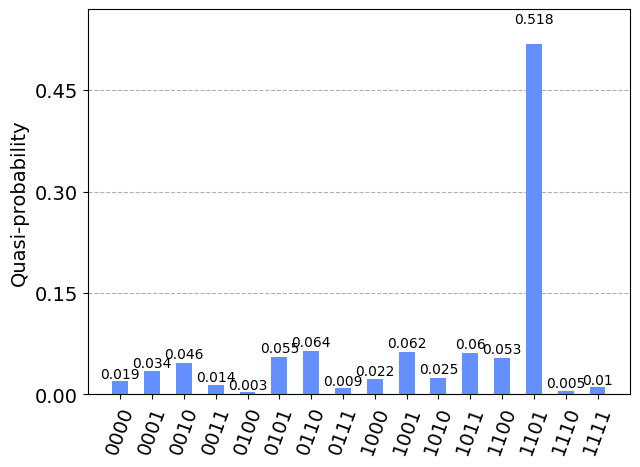

In [69]:
plot_histogram(QAOA_objective.set_circuit(theta=theta_f).get_state_probabilities(reverse_states=True))